<a href="https://colab.research.google.com/github/hflautert/AnomalyDetection/blob/main/MediaMovelAnomaliaMQTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carregar arquivo de pacotes MQTT ao longo do tempo, aplicar media do últimos x intervalos de tempo e comparar com a média atual.

*Desevolvido no Google Colab.

Fonte de dados:
https://www.kaggle.com/datasets/cnrieiit/mqttset

Rede normal:
capture_1w.pcap

Ataque:
capture_malariaDoS.pcap

Descrição dos ataques:
https://www.mdpi.com/1424-8220/20/22/6578/htm

Para gerar as estatísticas, os arquivos foram abertos com WireShark, aplicado filtro MQTT. Posteriormente gerado dados na aba Estatíticas, I/O Graph, salvo como csv.

In [ ]:
# Importando bibliotecas
from google.colab import drive 
# Manipulaçao de caminhos/arquivos
import os
# Manipulação de matrizes e operações matemáticas de alto nível
import numpy as np
# Geração de gráficos
import matplotlib.pyplot as plt

In [ ]:
# Abrindo drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


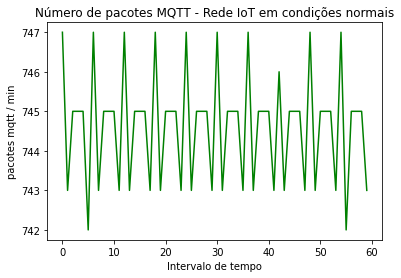

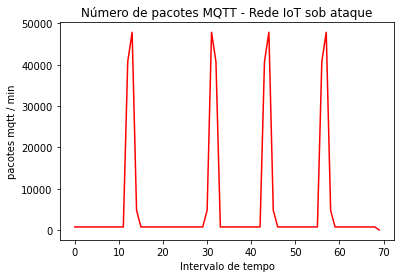

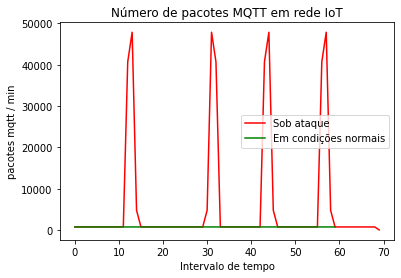

In [ ]:
# Carregando dados
dados_ataque = np.loadtxt(os.path.join('Estatisticas','mqtt.csv'), delimiter=',',skiprows=1)
dados_normal = np.loadtxt(os.path.join('Estatisticas','mqtt_ok.csv'), delimiter=',',skiprows=1)

# Recorte para melhor visualização dos dados
vis_ataque = dados_ataque[:, 1]
vis_normal = dados_normal[2940:3000, 1]

# Condicoes normais
plt.plot(vis_normal, color = 'g')
plt.title('Número de pacotes MQTT - Rede IoT em condições normais')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes mqtt / min')
plt.show()

# Sob ataque
plt.plot(vis_ataque, color = 'r')
plt.title('Número de pacotes MQTT - Rede IoT sob ataque')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes mqtt / min')
plt.show()

# Unindo linhas
plt.plot(vis_ataque, color = 'r', label = "Sob ataque")
plt.plot(vis_normal, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes MQTT em rede IoT')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes mqtt / min')
plt.legend()
plt.show()


Falso positivos: 0


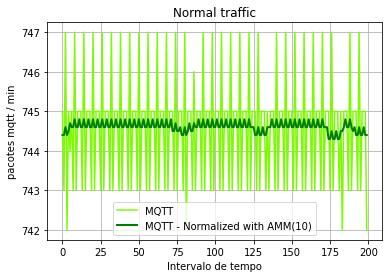

Total de ataques identificados: 4


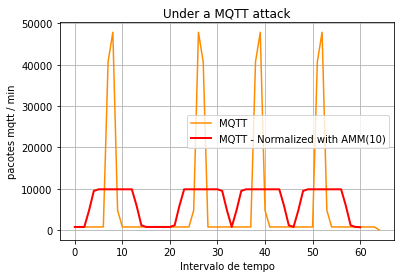

In [ ]:
# Carregando dados completos
pkts_ataque = dados_ataque[:, 1]
pkts_normal = dados_normal[1000:8500, 1]

v = np.lib.stride_tricks.sliding_window_view(pkts_ataque,10)
vn = np.lib.stride_tricks.sliding_window_view(pkts_normal,10)

media_mqtt_a = []
media_mqtt_n = []
cont_ataque = 0
cont_ok = 0
sob_ataque = 0

#-1000 temp testes
#for i in range(len(v)-1000):
for i in range(len(v)):
  media_mqtt_a.append(v[i].mean())
  #print (v[i].mean())
  if i<2: #sem base para comparacao
    #print ("menor q 2")
    pass
  else:
    #print("---")
    #print("antepenultima",v[i-2].mean())
    antpen_media=v[i-2].mean()
    #print("penultima",v[i-1].mean())
    pen_media=v[i-1].mean()
    #print("media atual",v[i].mean())
    media_atual=v[i].mean()
    #print(antpen_media,pen_media,media_atual)
    if (media_atual>pen_media*1.1) and (pen_media>antpen_media*1.1) and sob_ataque == 0:
      #print ("Crescimento de 10% nas ultimas 3 medicoes")
      cont_ataque += 1
      sob_ataque = 1
    if (antpen_media>pen_media) and (pen_media>media_atual):
      #print ("Media em queda, desarma sob ataque")
      sob_ataque = 0


# crescimento de 10% nos erros das ultimas 3 medias
# sob-ataque: ignora novos crescimentos - mesmo ataque
# desarma sob-ataque com queda nas ultimas 3 medias.
sob_ataque = 0

for i in range(len(vn)):
  media_mqtt_n.append(vn[i].mean())
  if i<2: #sem base para comparacao
    pass
  else:
    antpen_media=vn[i-2].mean()
    pen_media=vn[i-1].mean()
    media_atual=vn[i].mean()
    if (media_atual>pen_media*1.1) and (pen_media>antpen_media*1.1) and sob_ataque == 0:
      cont_ok += 1
      sob_ataque = 1
    if (antpen_media>pen_media) and (pen_media>media_atual):
      sob_ataque = 0


print ("Falso positivos:",cont_ok)
# Sob ataque x normal com media movel
plt.plot(pkts_normal[:200], color = 'lawngreen', label = "MQTT")
plt.plot(media_mqtt_n[:200], color = 'g',linewidth=2, label = "MQTT - Normalized with AMM(10)")
plt.title('Normal traffic')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes mqtt / min')
plt.legend()
plt.grid()
plt.show()

print ("Total de ataques identificados:",cont_ataque)
plt.plot(pkts_ataque[5:], color = 'darkorange', label = "MQTT")
plt.plot(media_mqtt_a[:], color = 'r',linewidth=2, label = "MQTT - Normalized with AMM(10)")
plt.title('Under a MQTT attack')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes mqtt / min')
plt.legend()
plt.grid()
plt.show()